# M1
Karl Jacobsen

## Introduction

## Franke-function

We start by importing the necessary Python modules:

In [131]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
from collections import OrderedDict
from scipy import linalg
from numpy.linalg import norm

We create data and plot the Franke-function with these data:

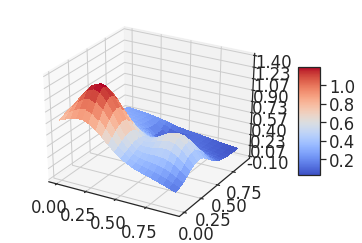

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
z = FrankeFunction(xPlot, yPlot)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Next we make a class, that has methods for computaion of the OLS and Ridge estimator. In order to avoid problems with singularity during the matrix inversions in the OLS and Ridge estimators, the SVD is used. The class also contains methods for computation of errors, parameter variances and different resempling techniques.

In [226]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree, trueFunction=False, lambdaValue=None):
        if trueFunction:
            self.trueFunction = trueFunction
        if lambdaValue != None:
            self.lambdaValue = lambdaValue
        else:
            self.lambdaValue = 0.
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.numberOfObservations = len(self.xOrg)
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        #self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        #self.x, self.y, self.z = np.ravel(xPlot), np.ravel(yPlot), np.ravel(zPlot)
        self.x, self.y, self.z = np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1), np.reshape(zPlot, -1, 1)

        self.degree = degree
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        #XHat = np.c_[x, y] 
        self.XHat = np.c_[x, y] 
        poly = PolynomialFeatures(self.degree)
        self.XHat = poly.fit_transform(self.XHat)
        #self.XHat = poly.fit_transform(XHat)

    def estimate(self):
        XHat = self.XHat
        XHatTdotXHatShape = np.shape(XHat.T.dot(XHat))
        
        # Ridge Inverson
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat) + \
         #                            lambdaValue*np.identity(XHatTdotXHatShape[0])).dot(XHat.T).dot(self.z)
        
        # OLS inversion
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        
        # Linear system OLS
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat), np.dot(XHat.T, self.z))
        
        # Linear system, Ridge. NOT WORKING.
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat) + lambdaValue*np.identity(XHatTdotXHatShape[0]),\
         #                              np.dot(XHat.T, self.z))
        
        
        # SVD Ridge
        alphas = np.zeros(1)
        alphas[0] = self.lambdaValue
        U, s, Vt = linalg.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        self.betaHat = np.dot(d * U.T.dot(self.z), Vt).T
        self.betaHat = np.squeeze(self.betaHat)
        #print('shape beta ', np.shape(self.betaHat), 'type beta', type(self.betaHat))
        
    
    def predict(self):
        self.zPredict = self.XHat.dot(self.betaHat)

        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = (np.reshape(zPredict, np.shape(zPlot))).T
        #zPredictPlot = zPredictPlot.T
        
        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predicted')
        plt.show()
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('True')
        plt.show()        
        
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict = self.z, self.zPredict
        self.mse = mean_squared_error(z, zPredict)
        self.r2 = r2_score(z, zPredict)
        
        #print("Mean squared error: %.4f" % self.mse)
        #print('R2 score: %.4f' % self.r2)
        

    def calculateVarianceBeta(self):
        XHat = self.XHat
        betaHat = self.betaHat
        z = self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        #yFitted = XHat.dot(betaHat)
        yFitted = self.zPredict
        mse = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(mse)
        W = np.linalg.inv(XHat.T.dot(XHat) + self.lambdaValue*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        self.varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        self.varBeta = np.diag(self.varBeta)
        #self.varBeta = np.diag(coefficientVariancesSLR)
        self.varOLS = np.diag(coefficientVariancesSLR)
        
    def movingAvg(self, array):
        n = len(array)
        cumsum  = np.cumsum(array)
        movingAverage  = np.cumsum(array)
        for counter in range(len(array)):
            movingAverage[counter] = cumsum[counter]/(counter+1)
        return movingAverage    
    
    def runningVariance(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns, numberOfBetas = np.shape(betaList)
        varianceMatrix = np.zeros((numberOfRuns, numberOfBetas))

        for runNumber in range(numberOfRuns):
            for betaNumber in range(numberOfBetas):
                varianceMatrix[runNumber, betaNumber] = np.var(betaList[0:runNumber+1, betaNumber])
        return varianceMatrix
    
    def runningVarianceVector(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns = len(betaList)
        varianceVector = np.zeros(numberOfRuns)

        for runNumber in range(numberOfRuns):
            varianceVector[runNumber] = np.var(betaList[0:runNumber+1])
        return varianceVector
    
    

    
    def errorBootstrap(self, bootstraps=2, plot=False): 
        models = []
        
        self.mseBootstrap = np.zeros(bootstraps)
        self.R2Bootstrap = np.zeros(bootstraps)
        self.mseTraining = np.zeros(bootstraps)
        self.R2Training = np.zeros(bootstraps)
        
        self.bootstraps = bootstraps
        betaList = [] # For variance calculation
        #VBT = []
        self.error2 = np.zeros(bootstraps)
        #averageZ = 0
        zPredictDict = OrderedDict() # Bias-variance decomposition
        noiseDict = OrderedDict()
        noiseDict2 = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()

        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                zPredictDict[i, j]  = []
                noiseDict[i, j]      = []
                #noiseDict2[i, j]      = []
                totalErrorDict[i, j] = []
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        #varianceMatrix2 = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        #noiseMatrix2 = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)
        
        #avgYmatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        zPredictMeanMatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))

        
        for iteration in range(self.bootstraps):
            zPredictMatrix = np.empty((self.numberOfObservations, self.numberOfObservations))
            zPredictMatrix[:] = np.nan
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)
            #print('\n trainingIndices \n', trainingIndices, '\n')
            '''
            xTraining1D = self.xPlot[trainingIndices[:,0], trainingIndices[:,1]]
            yTraining1D = self.yPlot[trainingIndices[:,0], trainingIndices[:,1]]
            zTraining1D = self.zPlot[trainingIndices[:,0], trainingIndices[:,1]]
            '''
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]
            
            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D        
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
         
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            #print('\n len(testIndices) \n', len(testIndices), '\n len(trainingIndices) \n', len(trainingIndices))
            '''
            xTest1D = self.xPlot[testIndices[:,0], testIndices[:,1]]
            yTest1D = self.yPlot[testIndices[:,0], testIndices[:,1]]
            zTest1D = self.zPlot[testIndices[:,0], testIndices[:,1]]
            '''
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            
            #print('\n xTest1D \n', xTest1D, '\n')
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            #self.estimate()
            self.predict()           # --> zPredict
            
            self.mseBootstrap[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Bootstrap[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                #noiseDict2[coordinate].append(self.z[index] - self.trueFunction(self.x[index], self.y[index]))# Always the same
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
                zPredictMatrix[coordinate[0]][coordinate[1]] = self.zPredict[index]
            models.append(zPredictMatrix)
            
            self.error2[iteration] = 0            
            for i in range(len(x)):
                self.error2[iteration] += (self.z[i] - self.zPredict[i])**2
            

        
        #zForTest = np.ravel(self.zPlot)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(zPredictDict, range(len(zPredictDict))):
            zPredictMean = np.nanmean(zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(zPredictDict[key])
            #varianceMatrix2[key[0], key[1]] = np.nanmean((zPredictDict[key] - zPredictMean)**2)
            #bias2Matrix[key[0], key[1]] = (zPredictMean - self.trueFunction(self.xOrg[key[0]], self.yOrg[key[1]]))**2
            #bias2Matrix[key[0], key[1]] = (zPredictMean - zForTest[index])**2
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            #noiseMatrix2[key[0], key[1]] = np.nanvar(noiseDict2[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
                    
            zPredictMeanMatrix[key[0], key[1]] = np.nanmean(zPredictDict[key])

            

        #print('\n varianceMatrix/varianceMatrix2 \n', np.divide(varianceMatrix,varianceMatrix2), '\n ') 
        # Result: they equal
        
        #print('\n totalErrorMatrix/totalErrorMatrixForTesting \n', np.divide(totalErrorMatrix,totalErrorMatrixForTesting), '\n ') 
        # Result: different
        
        #print('\n noiseMatrix/noiseMatrix2 \n', np.divide(noiseMatrix,noiseMatrix2), '\n ') 
        # Result: Numbers ar 10**31
        
        #print('\n noiseMatrix2 \n',noiseMatrix2, '\n ') 
        # Very small elements, 10**-31 --> Reason: The difference between the real function and the data always the same
        
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        #self.variance2 = np.nanmean(np.reshape(varianceMatrix2, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        #print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
         #     self.bias2, self.variance, self.noise, self.bias2+ self.variance+self.noise, self.totalError) 
        
        #from numpy.linalg import norm
        variancePython = 0
        for prediction in models:
            #print('prediction ', prediction)
            for row in range(self.numberOfObservations):
                for col in range(self.numberOfObservations):
                    if not np.isnan(prediction[row][col]):
                        '''print('row, col, ', row, col, '\n zPredictMeanMatrix[row][col] \n', \
                             zPredictMeanMatrix[row][col], '\n prediction[row][col] \n', \
                             prediction[row][col]) '''
                        variancePython += (zPredictMeanMatrix[row][col] - prediction[row][col])**2
        variancePython = np.sqrt(variancePython)
        #print('\n fValues.size ', fValues.size, 'self.bootstraps ', self.bootstraps)
        variancePython /= fValues.size * self.bootstraps
        self.variancePython = variancePython
        
        zPredictMeanMatrix = np.reshape(zPredictMeanMatrix, -1, 1)
        bias_2 = norm(zPredictMeanMatrix - fValues)
        bias_2 /= fValues.size #example python
        self.biasPython = bias_2
        
        #betaList = np.array(betaList)
        self.error2 = np.sum(self.error2)
        self.mseBootStrapMA = self.movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = self.movingAvg(self.R2Bootstrap)
        self.betaRunning = self.movingAvg(betaList)
        self.varianceBetaBootstrap =  self.runningVariance(betaList)
        self.varMSE = self.runningVarianceVector(self.mseBootstrap)
        #self.VBT = np.array(VBT)
        #self.totalVBT = self.VBT[:,-1]
        
        # Bias-variance for cases when true function unknown
        self.varianceMSERealData = np.var(self.mseBootstrap)
        self.meanMSEsquaredRealData = (np.mean(self.mseBootstrap))**2
        self.mseTotalRealData = norm(self.mseBootstrap)
        self.mseTotalRealData = self.mseTotalRealData**2/self.bootstraps
        '''
        print('\n var+bias \n', self.varianceMSERealData + self.meanMSEsquaredRealData, \
             '\n mseTotal \n', self.mseTotalRealData )'''
        
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(np.arange(1,len(self.mseBootStrapMA)+1), self.mseBootStrapMA)
            ax.set_title('Bootstrap \n Running Mean MSE')
            ax.set_xlabel('Number of bootsraps')
            ax.set_ylabel('Running mean MSE')
            
            fig4, ax4 = plt.subplots()
            ax4.plot(np.arange(1,len(self.mseBootStrapMA)+1), (self.varMSE/self.mseBootStrapMA)*100)
            ax4.set_title('Bootstrap \n Running (Variance MSE/Mean MSE)*100')
            ax4.set_xlabel('Number of bootsraps')
            ax4.set_ylabel('Running variance MSE')
            
            fig2, ax2 = plt.subplots()
            ax2.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.R2BootstrapMA )
            ax2.set_title('Bootstrap \n Running Mean R2')
            ax2.set_xlabel('Number of bootsraps')
            ax2.set_ylabel('Running Mean R2')
            
            fig3, ax3 = plt.subplots()
            ax3.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.varianceBetaBootstrap )
            ax3.set_title('Bootstrap \n Var(Beta) (Running)')
            ax3.set_xlabel('Number of bootsraps')
            ax3.set_ylabel('Var(Beta)')
            
            '''
            fig5, ax5 = plt.subplots()
            ax5.plot(np.arange(1,len(self.R2BootstrapMA )+1),  self.betaRunning)
            ax5.set_title('Bootstrap \n Beta')
            ax5.set_xlabel('Number of bootsraps')
            ax5.set_ylabel('Beta')
            '''
            # HERE: 1) After reversal of index numbers, total error in bootstrap no longer sum of bias and viarnace
            # when zero noise, \
            #2) maybe possible use method as in pytjhon nb example. Just take average each
            # element.., 
            
    def kFold(self, numberOfFolds=3, shuffle=False):
        self.betaList = [] # For variance calculation
        self.zPredictDict = OrderedDict() # Bias-variance decomposition
        self.mseTraining = np.zeros(numberOfFolds)
        self.R2Training = np.zeros(numberOfFolds)        
        noiseDict = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()
        self.mseSciKit = np.zeros(numberOfFolds)
        self.R2SciKit = np.zeros(numberOfFolds)
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)    
        
        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                self.zPredictDict[i, j]   = []
                noiseDict[i, j]      = []
                totalErrorDict[i, j] = []
        
        if not shuffle:
            indices = []
            for i in range(self.numberOfObservations):
                for j in range(self.numberOfObservations):
                    indices.append((i,j))
            indices = np.array(indices)
        else:
            return None
        
        foldLength = int(round(self.numberOfObservations**2/numberOfFolds))
        
        for iteration in range(numberOfFolds):
            if iteration != range(numberOfFolds)[-1]:
                testIndices = indices[iteration*foldLength:(iteration+1)*foldLength]
            else:
                testIndices = indices[foldLength*iteration:]   
            
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            '''
            print('\n testIndices \n',testIndices)
            print('\n xPlot \n',self.xPlot)
            print('\n xTest1D \n',xTest1D)

            print('\n testIndices \n',testIndices)
            print('\n yPlot \n',self.yPlot)
            print('\n yTest1D \n',yTest1D)
            '''
            
            indices_rows = indices.view([('', indices.dtype)] * indices.shape[1])
            testIndices_rows = testIndices.view([('', testIndices.dtype)] * testIndices.shape[1])
            trainingIndices = np.setdiff1d(indices_rows, testIndices_rows).view(indices.dtype).reshape(-1, indices.shape[1])          
            #print('\n trainingIndices \n',trainingIndices)
            #print('\n testIndices \n',testIndices)
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]

            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D      
            #print('\n self.x \n', self.x)
            
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            self.betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            self.predict()           # --> zPredict
            self.mseSciKit[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2SciKit[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                self.zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
        #print('\n zPredictDict inside ', self.zPredictDict)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(self.zPredictDict, range(len(self.zPredictDict))):
            zPredictMean = np.nanmean(self.zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(self.zPredictDict[key])
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
            
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        
        # Bias-variance for cases when true function unknown
        self.varianceMSERealData = np.var(self.mseSciKit)
        self.meanMSEsquaredRealData = (np.mean(self.mseSciKit))**2
        self.mseTotalRealData = norm(self.mseSciKit)
        self.mseTotalRealData = self.mseTotalRealData**2/numberOfFolds
        '''print('\n var+bias \n', self.varianceMSERealData + self.meanMSEsquaredRealData, \
             '\n mseTotal \n', self.mseTotalRealData )'''
        

### Model selection. Least squares
We will approximate the Franke function with polynomial regression. In order to decide which polynomial order to use, we make comparisons of the results using different polynomial degrees in the training. The copmarisions are made on error measures such as the Mean Squared Error (MSE) and the R2 score. <br>

By comparing the performance of different polynomial degrees by MSE and R2 from traning data, one will probaly not find the best model. The error measures for the training data typically always decreases with the complexity of the model, leading to the false conclusion that the more complex the model, the better. The problem with a highly complex model, is that the predictions from this model will be highly variable with the input. A model very senesitive to the input data, does not generalize well, meaning that the model does not work well for other data than the data it was created with. This problem is called overfitting. <br>

Overfitting can be measured by measruing the preiction error from a given model on data that was not used in estimating the model. We split the data in training and test sets. Techniques for splitting the data in test and training sets are called resampling techniques. <br>

We will apply two different resampling techniques: K-fold and Bootstrapping. With the F-fold method, the data is split in K number of folds. One of the folds are chosen as the testing set, while the remaining folds are used for traning the model. This is repeated K number of times, each time with a different fold as the test set. We get K models, and we compute the error measures for all of them. Finally we averge the error measures over the models, getting scalars for the error measures for the given polynoial degree. <br>

With Bootstrapping, the other resampling technique, the data set is split into test and tranining set by random drawing. The tranining observations are drawn from the full dataset, with replacement. The number of observations in the training set equals the number of observations in the full data set. The replacement and the size of the training set implies that there almost always will be duplicats in the training set. The observations not contained in the training set makes up the test set. Typcally the split is 65/35 for training/test observations.<br>

The next figure shows $MSE_{training}$ and $MSE_{testing}$ as functions of the polynomial degree.

### MSE: K-fold, training

In [231]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
noiseSize  = 0.
zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 5
degrees = np.arange(1, maxDegree+1)
bootstraps = 100
numberOfFolds = 10
biasBS, varianceBS, noiseBS, totalErrorBS, mseBS, mseTrainingBS, r2BS, biasPython , variancePython, mseAllBs, \
biasRealDataBS, varianceRealDataBS, totalMSErealDataBS = \
[], [], [], [], [], [], [], [], [], [], [], [], []
biasKF, varianceKF, noiseKF, totalErrorKF, mseKF, mseTrainingKF, \
r2KF, mseKFStd, biasRealDataKF, varianceRealDataKF, totalMSErealDataKF, betasKF, varBetasKF= \
[], [], [], [], [], [], [], [], [], [], [], [], []
R2training, mseTraining, varBetasTraining = [], [], []

for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    ls.createDesignMatrix()
    ls.estimate()
    ls.predict()
    ls.calculateErrorScores()
    ls.calculateVarianceBeta()
    mseTraining.append(ls.mse)
    R2training.append(ls.r2)
    varBetasTraining.append(ls.varBeta)
    
    lsBS = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsBS.errorBootstrap(bootstraps=bootstraps, plot=False)
    biasBS.append(lsBS.bias2)
    varianceBS.append(lsBS.variance)
    noiseBS.append(lsBS.noise)
    totalErrorBS.append(lsBS.totalError)
    mseBS.append(np.mean(lsBS.mseBootstrap))
    mseTrainingBS.append(np.mean(lsBS.mseTraining))
    r2BS.append(np.mean(lsBS.R2Bootstrap))
    biasPython.append(lsBS.biasPython)
    variancePython.append(lsBS.variancePython)
    biasRealDataBS.append(lsBS.meanMSEsquaredRealData)
    varianceRealDataBS.append(lsBS.varianceMSERealData)
    totalMSErealDataBS.append(lsBS.mseTotalRealData)
   
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    lsKF.calculateVarianceBeta()
    varBetasKF.append(lsKF.varBeta)
    biasKF.append(lsKF.bias2)
    varianceKF.append(lsKF.variance)
    noiseKF.append(lsKF.noise)
    totalErrorKF.append(lsKF.totalError)
    mseKF.append(np.mean(lsKF.mseSciKit))
    mseKFStd.append(np.std(lsKF.mseSciKit)/np.mean(lsKF.mseSciKit))
    mseTrainingKF.append(np.mean(lsKF.mseTraining))
    r2KF.append(np.mean(lsKF.R2SciKit))
    biasRealDataKF.append(lsKF.meanMSEsquaredRealData)
    varianceRealDataKF.append(lsKF.varianceMSERealData)
    totalMSErealDataKF.append(lsKF.mseTotalRealData)
    betasKF.append(lsKF.betaList)

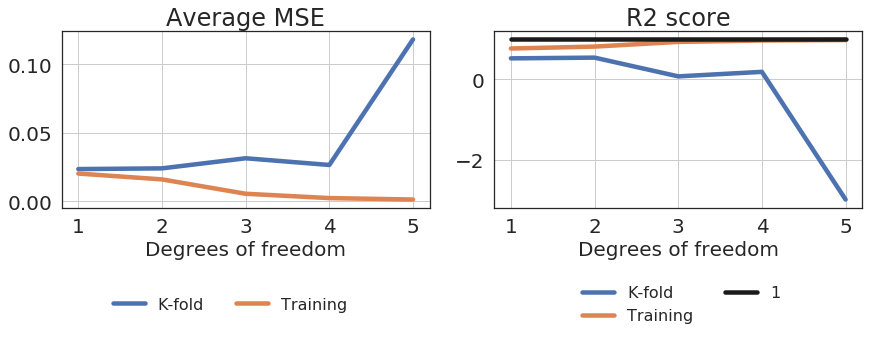

In [210]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(12.5,5))  # 1 row, 2 columns
fontSize  = 16
legends = ['K-fold', 'Training'] #, 'Bootstrap MSE', 'K-fold MSE'
legendsR2 = ['K-fold', 'Training', '1']
mseMethods =  mseKF, mseTraining
r2Methods = r2KF , R2training
xTicks = np.arange(1,maxDegree+1, 1)
lastDegree = 5

for mseMethod, r2Method, label in zip(mseMethods, r2Methods, legends): # mseTrainingBS, mseTrainingKF,
    ax.plot(degrees[:lastDegree], mseMethod[:lastDegree])#, label=label)
    ax2.plot(degrees[:lastDegree], r2Method[:lastDegree])#, label=label)
ax2.plot(degrees[:lastDegree], np.ones(len(degrees[:lastDegree])), 'k')
    
#ax2.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree]))


ax.set_title('Average MSE', fontsize = fontSize*1.5)
ax2.set_title('R2 score', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax2.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(xTicks[:-5])
ax2.set_xticks(xTicks[:-5])
legendsAx2 = [r'$Bias^2$', 'Variance']


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(0.1, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)


box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax2.legend(legendsR2, loc='center left', bbox_to_anchor=(0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax2.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
plt.tight_layout()

The figure to the left above shows that for the training set the MSE always decreases with the degrees of freedom. We also see that the K-fold method gives higher MSE compared to the training set. Contrary to the training MSE, the K-fold MSE reaches a point where more complexity with regards to polynomial degree does not make the fit better. The best polynomial degree seems to be everything below 5, since the MSE of the K-fold method is pretty constant in this range. <br>

Another way to study the fit, is by computation of the so-called R2-score. An R2-score equalt to one is a perfect fit, and the R2 is normally between zero and one. The figure to the right above shows the same story as the figure to the left. Furthermore, we see that the quality of the fit for the training set becomes extremely good, since the R2-score approaches one when the degrres of freedom increse. The R2 score for the K-fold method actually becomes negative, which is a rather seldom phenomenon, suggesting that the fit is no longer good. <br>

The reason for the increase in MSE with complexity has to do with increased variance due with model complexity. When the model is complex, a small change in the data will affect the estimation results to a high degree. Hence the MSE will vary a lot between the different folds in the K-fold validations when the model is complex. This phenomenon is shown in the figure below, where we have decoposed the MSE of all MSE's at given degrees of freedom into contributions from the squared bias and the variance.

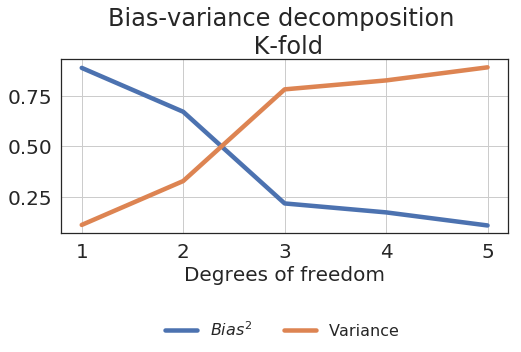

In [204]:
legends = ['K-fold', 'Training'] #, 'Bootstrap MSE', 'K-fold MSE'
r2Methods = r2KF , R2training


xTicks = np.arange(1,maxDegree+1, 1)
lastDegree = 5

fig, ax = plt.subplots(figsize=(8,4))
#for r2Method, label in zip( r2Methods, legends): # mseTrainingBS, mseTrainingKF,
 #   ax.plot(degrees[:lastDegree], r2Method[:lastDegree])#, label=label)
ax.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
ax.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree]))

ax.set_title('Bias-variance decomposition \n K-fold', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(xTicks[:-5])
legendsAx2 = [r'$Bias^2$', 'Variance', '1']


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legendsAx2, loc='center left', bbox_to_anchor=(0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
#plt.tight_layout()

The figure shows that the bias contribution to the K-folds MSE decreeses, while the variance constribution increases, with the degrees of freedom. This observation, reduced bias and increased variance with complexity, is classical for overfitting. <br>

In [237]:
for i in range(len(varBetasTraining)):
    print('\n ', varBetasTraining[i], '\n')
#print((varBetasTraining))


  [0.00655224 0.01825904 0.0099356 ] 


  [0.01600859 0.21427416 0.17363809 0.23552124 0.13396799 0.15332821] 


  [0.01258227 0.4884426  0.46875187 2.51191928 1.43321085 2.00045784
 1.33437044 0.7584957  0.90746322 0.80717516] 


  [1.05016166e-02 8.73890151e-01 1.10660918e+00 1.26483725e+01
 7.84519559e+00 1.45559797e+01 3.17286002e+01 1.53331917e+01
 1.81879634e+01 2.95312240e+01 9.79495602e+00 5.35831737e+00
 6.40634161e+00 5.95667265e+00 6.94550170e+00] 


  [1.02507574e-02 1.76964163e+00 2.26228990e+00 7.54608526e+01
 3.43836467e+01 5.88608878e+01 6.42602047e+02 1.67038675e+02
 2.17802894e+02 2.99335270e+02 1.05782409e+03 2.13963835e+02
 2.24341363e+02 3.12758347e+02 3.25865258e+02 2.24729317e+02
 5.11686083e+01 5.88754851e+01 5.47058648e+01 6.66789359e+01
 5.03287649e+01] 



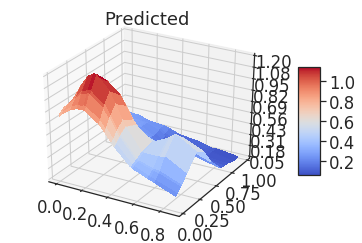

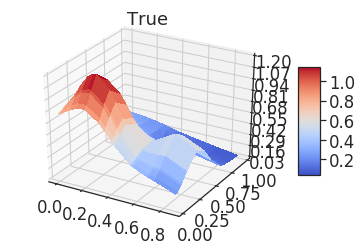


 np.mean(ls.mseBootstrap) 
 0.0014645847563403683 


 bias2, variance, noise, sum(bias2, variance, noise), totalError 0.048468060103545554 0.0011962181862682953 0.0 0.04966427828981385 0.0014968570388459244


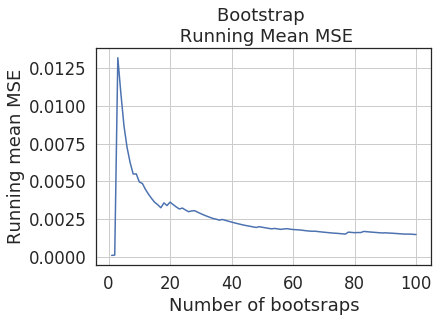

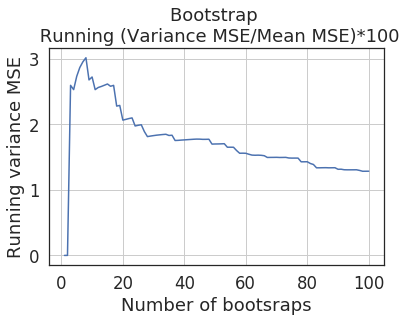

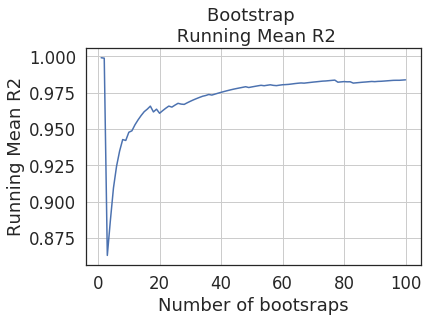

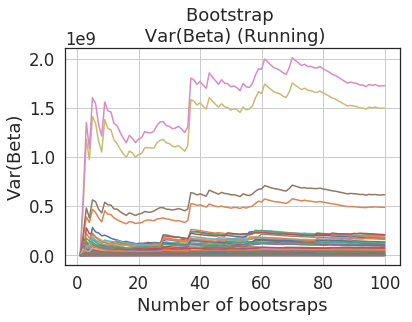

In [12]:
# Testing class

'''
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
'''
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)
degree = 10
ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()

ls.estimate()
#ls.fit()
ls.predict()
ls.plot()
ls.calculateErrorScores()
ls.calculateVarianceBeta()

#print('\n Theoretical Var(beta) training set \n', ls.varBeta, '\n')
ls.errorBootstrap(bootstraps=100, plot=True)

print('\n np.mean(ls.mseBootstrap) \n', np.mean(ls.mseBootstrap), '\n')

print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
              ls.bias2, ls.variance, ls.noise, ls.bias2+ ls.variance+ls.noise, ls.totalError)

#print('\n Bootstrap Var(Beta) \n', ls.varianceBetaBootstrap[-1], '\n')

#print('\n Variance diagonal', ls.varOLS, '\n')


#np.savetxt('XHat', ls.XHat)

#print('\n Var(Beta): (boot/theory-1)*100 \n', (ls.varianceBetaBootstrap[-1]/ls.varBeta-1)*100, '\n')

#print('\n (MSEtotal VBT/MSE-1)*100 \n', (ls.VBT/ls.mseBootstrap-1)*100)

#print('\n (MSEtotal VBT/erro2-1)*100 \n', (ls.VBT/ls.error2-1)*100)


The plot above shows tha there is a huge difference between the predicted and the true solution in a small area of the domain. At most the predicted solution is approximately 20 times larger than the true solution. The error scores are very good. However, looking at the figure above, we see that low error scores are no guarantee for the fit being good over the whole domain.

## Bias-variance trade-off
### Bootstrap Bias-variance

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:251: RuntimeWarning: Mean of empty slice
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:252: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:257: RuntimeWarning: Mean of empty slice
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: Mean of empty slice



 bias [0.07855820061228831, 0.07883308743615246, 0.07870390401893108, 0.11408799866524003, 0.13861592677079176, 0.16769581668097913, 0.1706964247572531, 0.1765162626741842, 0.19918973351912267, 0.18823633971032178, 0.21147972428827316, 0.19215266918569177, 4.678216429049978, 16.39652048836759] 
 variance [0.0008977027631585983, 0.001338124183702607, 0.002344106022110967, 0.002716921844474941, 0.0038250792587904234, 0.0028934705576760446, 0.004489173517203135, 0.003377956987781016, 0.00783324361065676, 0.009033557455083704, 0.03732868292022713, 0.03230834571649178, 6.779568428133206, 40.863810676761425] 
 noise [0.1710151049826209, 0.17098738681173667, 0.171079991146344, 0.17082349742412475, 0.17065239141351923, 0.17134052693570168, 0.17175469478100747, 0.17145107555545233, 0.1702326859885246, 0.1708383568860863, 0.16742692667731293, 0.1718332181995997, 0.16949017604116287, 0.17074940082234208] 
 totalError [0.16789903912280693, 0.14719216430694887, 0.14013292187393572, 0.1277274192343

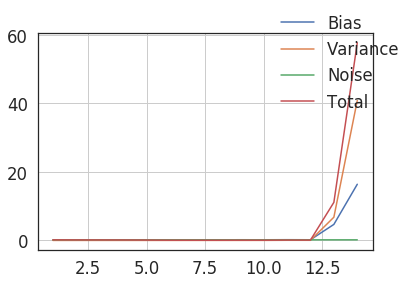

In [14]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

noiseSize  = 0.5

zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 15
degrees = np.arange(1, maxDegree)
bootstraps = 10
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

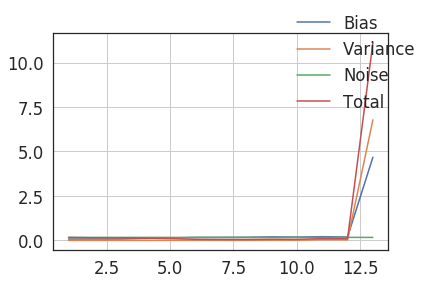

In [18]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees[:-1], variables[i][:-1], label=legends[i][:-1])
fig.legend(legends)

### K-fold bias-variance

Scores: [7.57344301e-01 9.02314094e-05 3.30508203e-05 5.75798496e-05
 3.30379121e-04 1.14593193e-04 1.77685149e-04 9.83613980e-04
 2.69014016e-03 1.86938915e+02]
Mean: 18.770073645372296
Standard deviation: 56.056734500419694

 bias [0.05231905499818193, 0.05087077636322805, 0.07260701511127321, 0.07595821527455154, 0.16794332596679692, 0.5023742241315416, 0.20119253226422346, 2.2789582989304726, 1.5520006717876236, 18.78741602111141] 
 variance [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 noise [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 totalError [0.023597971471673956, 0.024114605358293274, 0.031493417426785256, 0.026590736682582022, 0.11831234088999533, 0.45889431887642873, 0.15532443594195977, 2.2248151040476345, 1.5058034591630767, 18.770073645372296]


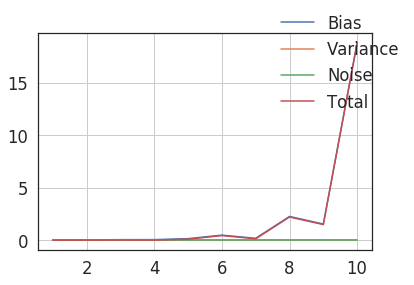

In [19]:
# Testing K-fold

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

maxDegrees = 10
degrees = np.arange(1,maxDegrees+1)
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    ls.kFold(numberOfFolds=10)
    ls.mseSciKit
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)    
display_scores(ls.mseSciKit)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )


### Bootstrap other function


 bias [6.460977729012354, 6.4247868285625485, 7.410308058939734, 10.043661354721847, 10.410892584660855, 10.682347113315762, 10.680927219466508, 12.943143762327235, 13.13348077278737, 17.171096058428393] 
 variance [0.36348175514425096, 0.4206319645108042, 0.6690003924354321, 0.9285413633280574, 1.3231919939058003, 1.9739625064603155, 3.2036237096114455, 3.457993689373818, 12.43350404956437, 36.08877429037024] 
 noise [34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638] 
 totalError [40.64730466590745, 29.684404784607935, 29.154477939417575, 27.126700903344737, 27.887594557863576, 29.0589809647957, 31.527373684409927, 29.60387807293944, 39.401706001604296, 63.88545938557241] 
 totalErrorForTesting [41.514327386113, 41.53528669502975, 42.76917635333155, 45.6620706200063, 46.42395248052304, 47.346177521732464, 48.57441883103434, 51.091005353657444, 60

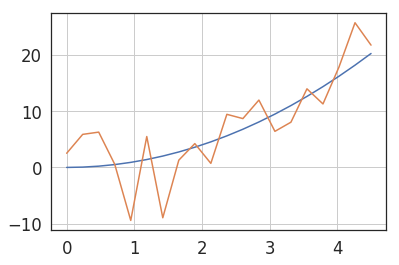

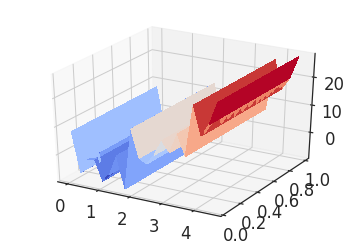

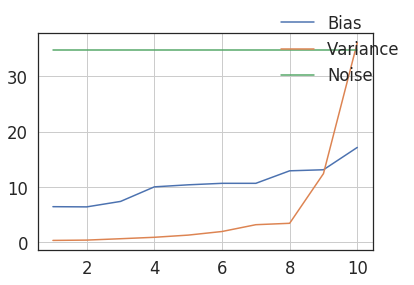

In [136]:
# Testing other function
def f(x, y):
    #z = 2 * np.sin(x * 1.5)
    z = x**2
    return z

def fWithNoise(z):
    z = z+ 5.*np.random.randn(len(z))
    return z

observationNumber = 20
x = np.linspace(0, 4.5, observationNumber)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

fig, ax  = plt.subplots()
z2 = f(x,y)
ax.plot(x, z2)
ax.plot(x, fWithNoise(z2))


xPlot, yPlot = np.meshgrid(x,y)
zPlot = f(xPlot, yPlot)
zPlot = fWithNoise(zPlot)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



maxDegrees = 11
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=f)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.fit()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
    totalErrorForTesting.append(ls.totalErrorForTesting)
    totalError2.append(ls.error2)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, \
      '\n totalErrorForTesting', totalErrorForTesting, '\n totalError2', totalError2, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

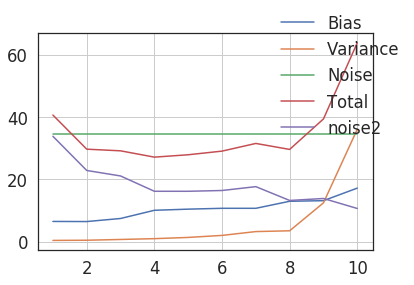

In [141]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total', 'noise2']
noiseFromOther = [totalError[i]-(bias[i] + variance[i]) for i in range(len(totalError))]
variables = [bias, variance, noise, totalError, noiseFromOther]

for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

# Ridge

In [142]:
degree = 10
lambdaValues = 0, .1, 1., 10, 100
for lambdaValue in lambdaValues:
    print('\n Lambda %.2f' %lambdaValue, '\n')
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    #print('betaHat my class: \n', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()


 Lambda 0.00 

Mean squared error: 19.5703
R2 score: 0.8105

 Lambda 0.10 

Mean squared error: 23.1529
R2 score: 0.7758

 Lambda 1.00 

Mean squared error: 23.7017
R2 score: 0.7705

 Lambda 10.00 

Mean squared error: 24.7083
R2 score: 0.7608

 Lambda 100.00 

Mean squared error: 26.5546
R2 score: 0.7429


In [56]:
# Ridge and bootstrap
maxDegrees = 10
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
lambdaValues = 0, 10
noiseValues = 0, 0.5
for noiseValue in noiseValues:
    print('\n Noise: %.2f' %noiseValue, '\n')
    zPlotInput = frankeNoise(zPlot, noiseValue)
    for lambdaValue in lambdaValues:
        print('\n Lambda %.2f' %lambdaValue, '\n')
        for degree in degrees:
            ls = LeastSquares(xPlot, yPlot, zPlotInput, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
            #ls.createDesignMatrix()
            #ls.estimate()
            #ls.predict()
            #ls.plot()
            #ls.calculateErrorScores()
            #ls.calculateVarianceBeta()
            ls.errorBootstrap(bootstraps=bootstraps, plot=False)
            bias.append(ls.bias2)
            variance.append(ls.variance)
            noise.append(ls.noise)
            totalError.append(ls.totalError)
        print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError,'\n' )


 Noise: 0.00 


 Lambda 0.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432] 
 variance [0.00019703927582549147, 0.00027854219117030214, 0.0001702517268844755, 0.00017231670198249527, 0.0001691164655527666, 0.0003106347550999, 0.0003221198861114912, 0.0003193882604039804, 0.0019148736185666526] 
 noise [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 totalError [0.020949094338105597, 0.01691429408877516, 0.0060544733733771975, 0.002855047200470675, 0.0017439541007165877, 0.001075800607583041, 0.0008283161640218979, 0.0006485902001865946, 0.0026760836891334956] 


 Lambda 10.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432, 0.029263310496706118, 0.026076975021

# Sci-kit learn comparisons
This section includes comparison of our own methods with corresponding Sci-Kit learn methods.

## Linreg

################### Sci-kit learn############################
Intercept:  0.8240973659564479
Coefficients:  [ 6.05940760e-09 -3.12043822e+00 -2.04351648e+00  4.60435974e+01
  5.56035630e+01  3.02807407e+01 -2.20968238e+02 -2.43795827e+02
 -2.09677399e+02 -1.48194377e+02  4.44942088e+02  4.34315115e+02
  6.91114425e+02  3.56060494e+02  2.95207523e+02 -4.11738038e+02
 -4.23955473e+02 -7.80426685e+02 -7.59964224e+02 -4.01591141e+02
 -2.61183407e+02  1.52527117e+02  2.68618480e+02  2.62716755e+02
  7.00470844e+02  3.01086137e+02  3.06084510e+02  8.42758003e+01
 -8.22924166e+00 -9.04889136e+01  2.19137737e+01 -1.94735897e+02
 -1.52296559e+02 -3.91227650e+01 -1.01928629e+02  1.14757139e+00]
Mean squared error: 0.0005
R2 score: 0.9936

################### My class############################
betaHat my class:  [   0.82409737   -3.12043822   -2.04351648   46.0435974    55.60356304
   30.28074066 -220.96823807 -243.79582695 -209.67739943 -148.19437664
  444.94208756  434.31511529  691.11442499 

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


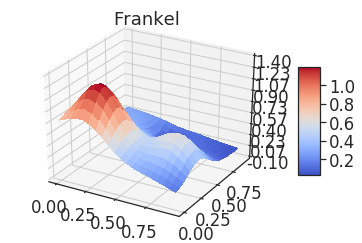

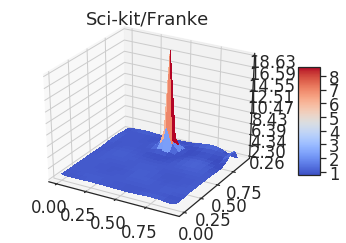

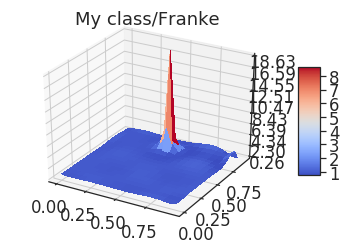

In [65]:
# Scitkit learn. Testing whether our code gives the same mse and R2 on the training set as scl.
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


XHat = np.c_[x, y]
degree = 7
polynomialDegree = degree
poly = PolynomialFeatures(polynomialDegree)
XHat = poly.fit_transform(XHat)

print('################### Sci-kit learn############################')
linreg = LinearRegression()
linreg.fit(XHat, z)
predictScitKit = linreg.predict(XHat)


print('Intercept: ', linreg.intercept_)
print('Coefficients: ', linreg.coef_)
print("Mean squared error: %.4f" % mean_squared_error(z, predictScitKit))
print('R2 score: %.4f' % r2_score(z, predictScitKit))

print('\n################### My class############################')

ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()
ls.estimate()
print('betaHat my class: ', ls.betaHat)
ls.predict()
ls.calculateErrorScores()
print('Predictions: zPredict/predictScitKit \n', ls.zPredict/predictScitKit)
print('XHat my class from outside/Xhat before into class \n', ls.XHat/XHat)


##############################PLOTS###################################
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Frankel')
plt.show()

predictScitKitPlot = np.reshape(predictScitKit, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictScitKitPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sci-kit/Franke')
plt.show()

predictMyClassPlot = np.reshape(ls.zPredict, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictMyClassPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('My class/Franke')
plt.show()

### K-fold: MSE. Own vs sci-kit


 Manually calculated MSE/ MSE sci-kit-function  
 [1. 1. 1. 1. 1. 1. 1.]


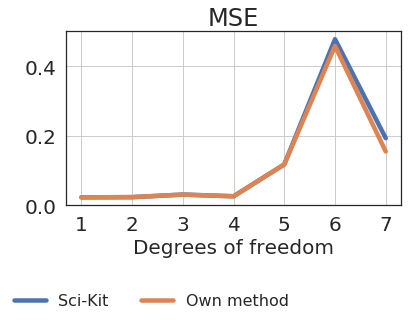

In [46]:
# Sci-kit learn Cross validation

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

#x = np.linspace(0,1,5)
#y = np.linspace(0,1,5)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


def display_scores(scores):
    #print("Scores:", scores)
    #print("Mean:", scores.mean())
    #print("Standard deviation:", scores.std())
    return  scores.mean(), scores.std()

mses = []
mseKF = []
error = []
maxDegrees = 7
numberOfFolds = 10
linreg = LinearRegression()

for degree in range(1, maxDegrees+1):
    poly = PolynomialFeatures(degree)
    XHat = np.c_[x, y]
    XHat = poly.fit_transform(XHat)
    lin_scores = cross_val_score(linreg, XHat, z,
                             scoring="neg_mean_squared_error", cv=numberOfFolds)
    lin_rmse_scores = -lin_scores
    mse, std = display_scores(lin_rmse_scores)
    mses.append(mse)
    
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    mseKF.append(np.mean(lsKF.mseSciKit))
    error.append(lsKF.totalError)

print('\n Manually calculated MSE/ MSE sci-kit-function  \n', np.array(error)/np.array(mseKF))
    
degrees = np.arange(1, maxDegrees+1)
fig, ax = plt.subplots()
legends = ['Sci-Kit', 'Own method']#
methods = mses, mseKF#, error
for degree, method, label in zip(range(1, maxDegrees+1), methods, legends):
    ax.plot(degrees, method, label=label)
#fig.legend(legends)


ax.set_title('MSE', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(degrees)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)